# Detecting and Clustering Seqlets with Modisco 

In this tutorial, we will explore how to use Modisco within the Decima framework to detect and cluster seqlets—short, high-scoring regions of DNA that are important for model predictions. Modisco (Motif Discovery from Importance Scores) is a powerful tool designed to analyze attribution scores from deep learning models. It identifies recurring patterns, or "motifs," by first locating seqlets—short subsequences with high attribution—and then clustering these seqlets based on similarity. This process helps uncover biologically meaningful sequence motifs that drive the model's predictions, providing insights into regulatory elements and sequence features learned by the model. We will walk through the steps of running Modisco on attribution data, from detecting seqlets to clustering them into motifs, and interpreting the results.


## CLI API

In this tutorial, we'll walk through a practical example of using Decima's CLI API to analyze neuronal cells and uncover how they differ from non-neuronal cells based on the major regulators. Let's first list avaliable cell types: 

In [1]:
! decima query-cell "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'"

wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:02.0 (1590.8MB/s)
	cell_type	tissue	organ	disease	study	dataset	region	subregion	celltype_coarse	n_cells	total_counts	n_genes	size_factor	train_pearson	val_pearson	test_pearson
agg_1112	CGE interneuron	Amygdala_Amygdala	CNS	healthy	jhpce#tran2021	brain_atlas	Amygdala	Amygdala		674	17421456.0	16954	42512.927350555474	0.9454484906394379	0.8549755331049285	0.8667663764982964
agg_1113	CGE interneuron	Amygdala_Basolateral nuclear group (BLN) - lateral nucleus - La	CNS	healthy	SCR_016152	brain_atlas	Amygdala	Basolateral nuclear group (BLN) - lateral nucleus - La		3653	43170604.0	17556	43343.31426365281	0.9556543498602063	0.8580799006688026	0.8653460664237342
agg_1114	CGE interneuron	Amygdala_Bed nucleus of stria terminalis and nearby - BNST	CNS	healthy	SCR_

The main arguments for the `decima modisco` CLI command allow you to customize motif discovery for your specific biological question. The `--top-n-markers` argument restricts the analysis to the top N marker genes, focusing on the most distinguishing genes for the selected cell types if not provided all genes are used. The `--max-seqlets` parameter sets an upper limit on the number of seqlets (short, high-scoring regions) extracted per metacluster, which can help manage memory usage and computation time. The `--tss-distance` option defines the window size (in base pairs) around the transcription start site to consider for motif discovery. 

 The `--tasks` argument lets you specify cell types or conditions of interest using a query string, such as `"cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'"` to select healthy CNS neurons. The `--transform` argument determines how attributions are aggregated or contrasted. For example, `"specificity"` compares the selected tasks (e.g., neurons) against the background (e.g., all other cells), highlighting features specific to the chosen group. Alternatively, `"aggregate"` simply sums attributions across the selected tasks.

The `--batch-size` and `--num-workers` options control parallelization and resource usage during computation. The `--model` argument selects which model replicate or checkpoint to use, and the `-o` or `--output-prefix` sets the path prefix for output files and reports.

In [2]:
! decima modisco  \
    --top-n-markers 50 \
    --max-seqlets 5000 \
    --tss-distance 5000  \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --transform "specificity" \
    --batch-size 1 \
    --model v1_rep0 \
    -o example/modisco_neurons

decima - INFO - Using device: 0
decima - INFO - Loading model v1_rep0 and metadata to compute attributions...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'rep0:latest', 720.03MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.8 (873.8MB/s)
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.6 (1915.4MB/s)
/home/celikm5/Projects/decima/src/decima/interpret/attributer.py:66: UserWarning: `off_tasks` is not provided. Using all other tasks as off_tasks.
Computing attributions...: 100%|████████████████| 50/50 [00:42<00:00,  1.17it/s]
decima - INFO - Loading metadata for model v1_rep0...
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.6 (1927.1MB/s)
Loading attributions and sequences...: 100%|████| 50/50 [00:08<00:00,  5.57

 The analysis creates the following files:
 - `example/modisco_neurons.h5`: HDF5 file containing the discovered motifs and seqlets generated by modisco.
 - `example/modisco_neurons_patterns.h5`: HDF5 file with processed motif patterns generated by TF-Modisco see TF-modisco API.
 - `example/modisco_neurons_report/`: Directory containing HTML and image reports of discovered motifs.
 - `example/modisco_neurons_seqlets.bed`: BED file with genomic locations of seqlets.
 - `example/modisco_neurons_*.attributions.h5`: HDF5 file containing the raw attribution scores for each input sequence and gene for each replicate. This file is used as input for motif discovery and can be inspected to understand which regions of the genome are most important for model predictions.
 - `example/modisco_neurons_*.attributions.bigwig`: Average attribution scores for each base across all input sequences, stored in BigWig format for visualization in genome browsers.

In [3]:
! ls example/modisco_neurons*

example/modisco_neurons.attributions.bigwig
example/modisco_neurons.attributions.h5
example/modisco_neurons.modisco.h5
example/modisco_neurons.seqlets.bed
example/modisco_neurons.warnings.qc.log

example/modisco_neurons_report:
ARNT2.H13CORE.0.P.B.png       PAX4.H13CORE.1.S.C.png
ARNT.H13CORE.1.P.B.png	      PO3F2.H13CORE.1.S.B.png
ATF2.H13CORE.1.P.B.png	      PO4F2.H13CORE.0.S.B.png
ATF3.H13CORE.2.P.B.png	      PO6F1.H13CORE.0.SM.B.png
ATF4.H13CORE.0.P.B.png	      RORB.H13CORE.0.SM.B.png
ATF4.H13CORE.1.S.B.png	      SATB1.H13CORE.0.P.B.png
BACH2.H13CORE.1.SM.B.png      SNAI2.H13CORE.0.PSM.A.png
BATF2.H13CORE.0.PSG.A.png     SOX11.H13CORE.0.P.B.png
CEBPG.H13CORE.2.P.B.png       SP140L.H13CORE.0.PSGIB.A.png
CLOCK.H13CORE.1.PS.A.png      SP2.H13CORE.1.P.B.png
CREB1.H13CORE.0.PSM.A.png     SRBP1.H13CORE.0.P.B.png
DDIT3.H13CORE.0.P.B.png       STAT1.H13CORE.1.P.B.png
ELK4.H13CORE.0.PSM.A.png      STAT2.H13CORE.0.P.B.png
ERR3.H13CORE.0.PSM.A.png      STF1.H13CORE.0.PSM.A.png
FEV.H13CORE.0.S

The following file generates an HTML report with motif visualizations and detailed statistics for each discovered pattern.

In [4]:
from IPython.display import HTML, Image

HTML(filename="example/modisco_neurons_report/motifs.html")

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
pos_patterns.pattern_0,92,,,ZN529.H13CORE.0.P.B,0.086240,,PO6F1.H13CORE.0.SM.B,0.336992,,SOX11.H13CORE.0.P.B,1.000000,
pos_patterns.pattern_1,76,,,ZN776.H13CORE.0.P.C,0.517371,,ATF4.H13CORE.1.S.B,0.517371,,DDIT3.H13CORE.0.P.B,0.517371,
pos_patterns.pattern_2,74,,,KMT2A.H13CORE.0.P.B,0.000002,,ZN519.H13CORE.0.P.C,0.001973,,KMT2B.H13CORE.0.P.B,0.010821,
pos_patterns.pattern_3,73,,,ATF4.H13CORE.0.P.B,1.000000,,BATF2.H13CORE.0.PSG.A,1.000000,,YBOX1.H13CORE.0.SM.B,1.000000,
pos_patterns.pattern_4,71,,,ATF4.H13CORE.1.S.B,0.001862,,ATF3.H13CORE.2.P.B,0.002186,,CEBPG.H13CORE.2.P.B,0.002186,
pos_patterns.pattern_5,68,,,ZEB2.H13CORE.0.P.B,0.472675,,ZEB1.H13CORE.0.P.B,0.472675,,ITF2.H13CORE.1.PSM.A,0.472675,
pos_patterns.pattern_6,67,,,FOXJ2.H13CORE.1.SM.B,0.283216,,ATF2.H13CORE.1.P.B,0.283216,,ZBTB40.H13CORE.0.PSG.A,0.339175,
pos_patterns.pattern_7,66,,,KLF16.H13CORE.1.P.B,0.001949,,SP2.H13CORE.1.P.B,0.001949,,KMT2A.H13CORE.0.P.B,0.001949,
pos_patterns.pattern_8,66,,,ZN483.H13CORE.0.P.C,0.175568,,ZNF292.H13CORE.0.PSG.A,0.336695,,ZBT44.H13CORE.0.P.C,0.537918,
pos_patterns.pattern_9,61,,,ZEB2.H13CORE.0.P.B,0.053112,,ITF2.H13CORE.1.PSM.A,0.053112,,SNAI2.H13CORE.0.PSM.A,0.053112,


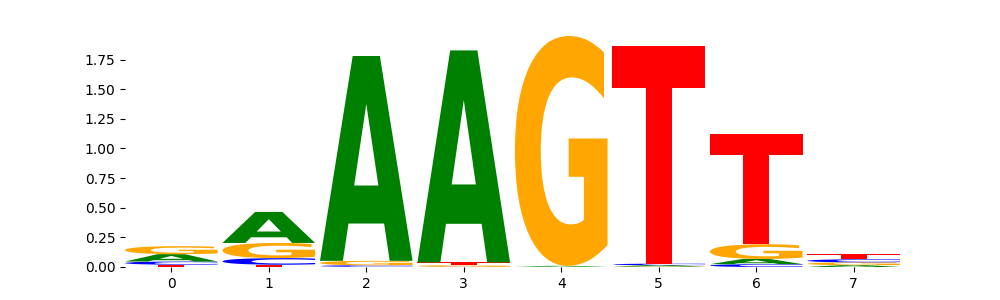

In [8]:
Image(filename="example/modisco_neurons_report/MYT1L.H13CORE.0.P.C.png")

### CLI Subcommands 

The Modisco API provides several subcommands to perform motif discovery and analysis in a stepwise manner.
Here is a detailed explanation of each step:

1. `modisco-attributions`: This subcommand computes attribution scores for each input sequence and gene. You can parallelize this step by running it on multiple GPUs. This is the only step that requires GPUs.

2. `modisco-patterns`: After computing attributions, this subcommand discovers motifs (patterns) by clustering
   the attribution scores using TF-Modisco. See the documentation of Modisco for the details of the output format.

3. `modisco-report`: This subcommand run tomtom to find motif matches for patterns motif images from the discovered patterns.

4. `modisco-seqlet-bed`: This subcommand extracts the genomic locations of seqlets (short, high-scoring
   regions) from the modisco results and writes them to a BED file. This allows for downstream analysis
   or visualization in genome browsers.

By running these subcommands in sequence, you can go from raw model predictions to interpretable motif
discovery, visualization, and downstream analysis.

Let's generate attributions for first replicate:

In [9]:
! decima modisco-attributions \
    --top-n-markers 50 \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --batch-size 1 \
    --model v1_rep0 \
    -o example/modisco_subcommands/modisco_neurons_0

decima - INFO - Using device: 0
decima - INFO - Loading model v1_rep0 and metadata to compute attributions...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'rep0:latest', 720.03MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.8 (863.9MB/s)
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.6 (1964.2MB/s)
/home/celikm5/Projects/decima/src/decima/interpret/attributer.py:66: UserWarning: `off_tasks` is not provided. Using all other tasks as off_tasks.
Computing attributions...: 100%|████████████████| 50/50 [00:42<00:00,  1.17it/s]


end second replicate:

In [10]:
! decima modisco-attributions \
    --top-n-markers 50 \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    --batch-size 1 \
    --model v1_rep1 \
    -o example/modisco_subcommands/modisco_neurons_1

decima - INFO - Using device: 0
decima - INFO - Loading model v1_rep1 and metadata to compute attributions...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'rep1:latest', 720.03MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:02.0 (361.9MB/s)
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.7 (1872.3MB/s)
/home/celikm5/Projects/decima/src/decima/interpret/attributer.py:66: UserWarning: `off_tasks` is not provided. Using all other tasks as off_tasks.
Computing attributions...: 100%|████████████████| 50/50 [00:42<00:00,  1.17it/s]


In [13]:
! ls example/modisco_subcommands/modisco_neurons*

example/modisco_subcommands/modisco_neurons_0.attributions.bigwig
example/modisco_subcommands/modisco_neurons_0.attributions.h5
example/modisco_subcommands/modisco_neurons_0.warnings.qc.log
example/modisco_subcommands/modisco_neurons_1.attributions.bigwig
example/modisco_subcommands/modisco_neurons_1.attributions.h5
example/modisco_subcommands/modisco_neurons_1.warnings.qc.log
example/modisco_subcommands/modisco_neurons.modisco.h5
example/modisco_subcommands/modisco_neurons.seqlets.bed

example/modisco_subcommands/modisco_neurons_report:
AHCTF1.H13CORE.0.B.B.png   NKX61.H13CORE.0.PS.A.png
ATF4.H13CORE.2.SM.B.png    NR1D1.H13CORE.0.P.B.png
BACH1.H13CORE.0.P.B.png    NR1I3.H13CORE.1.PSM.A.png
CEBPG.H13CORE.2.P.B.png    NR2F6.H13CORE.3.SM.B.png
CREB1.H13CORE.0.PSM.A.png  PATZ1.H13CORE.0.P.B.png
DDIT3.H13CORE.0.P.B.png    PO5F1.H13CORE.0.P.B.png
ELK4.H13CORE.0.PSM.A.png   PRD13.H13CORE.0.P.B.png
ERR1.H13CORE.0.PSM.A.png   RORG.H13CORE.0.M.C.png
ERR2.H13CORE.0.PSM.A.png   SNAI2.H13CORE.0.PS

Next, we will use the generated attributions as input for the pattern discovery step with MoDISco.
The `--attributions` argument expects a comma-separated list of attribution files (one per replicate or model),
which we produced in the previous step. These files contain the importance scores for each base in the input sequences,
and are required for MoDISco to identify recurring patterns (motifs).

In [12]:
! decima modisco-patterns \
    --attributions "example/modisco_subcommands/modisco_neurons_0.attributions.h5,example/modisco_subcommands/modisco_neurons_1.attributions.h5" \
    --top-n-markers 50 \
    --max-seqlets 5000 \
    --tss-distance 5000  \
    --tasks "cell_type.str.contains('neuron') and organ == 'CNS' and disease == 'healthy'" \
    -o example/modisco_subcommands/modisco_neurons

decima - INFO - Loading metadata for model ensemble...
wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:02.0 (1586.1MB/s)
Loading attributions and sequences...: 100%|████| 50/50 [00:10<00:00,  4.87it/s]
2025-11-25 12:24:08,734 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-11-25 12:24:08,740 - modisco-lite - INFO - Extracting seqlets for 50 tasks:
2025-11-25 12:24:08,740 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-11-25 12:24:08,753 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-11-25 12:24:08,810 - modisco-lite - INFO - - Computing isotonic thresholds
2025-11-25 12:24:08,841 - modisco-lite - INFO - - Refining thresholds
2025-11-25 12:24:09,134 - modisco-lite - INFO - - Extracting seqlets
2025-11-25 12:24:09,185 - modisco-lite - INFO - 

This step generates modisco.h5 file with discovered motifs and processed patterns.

In [14]:
! ls example/modisco_subcommands/modisco_neurons*

example/modisco_subcommands/modisco_neurons_0.attributions.bigwig
example/modisco_subcommands/modisco_neurons_0.attributions.h5
example/modisco_subcommands/modisco_neurons_0.warnings.qc.log
example/modisco_subcommands/modisco_neurons_1.attributions.bigwig
example/modisco_subcommands/modisco_neurons_1.attributions.h5
example/modisco_subcommands/modisco_neurons_1.warnings.qc.log
example/modisco_subcommands/modisco_neurons.modisco.h5
example/modisco_subcommands/modisco_neurons.seqlets.bed

example/modisco_subcommands/modisco_neurons_report:
AHCTF1.H13CORE.0.B.B.png   NKX61.H13CORE.0.PS.A.png
ATF4.H13CORE.2.SM.B.png    NR1D1.H13CORE.0.P.B.png
BACH1.H13CORE.0.P.B.png    NR1I3.H13CORE.1.PSM.A.png
CEBPG.H13CORE.2.P.B.png    NR2F6.H13CORE.3.SM.B.png
CREB1.H13CORE.0.PSM.A.png  PATZ1.H13CORE.0.P.B.png
DDIT3.H13CORE.0.P.B.png    PO5F1.H13CORE.0.P.B.png
ELK4.H13CORE.0.PSM.A.png   PRD13.H13CORE.0.P.B.png
ERR1.H13CORE.0.PSM.A.png   RORG.H13CORE.0.M.C.png
ERR2.H13CORE.0.PSM.A.png   SNAI2.H13CORE.0.PS

In [15]:
! decima modisco-seqlet-bed \
    --modisco-h5 example/modisco_subcommands/modisco_neurons.modisco.h5 \
    -o example/modisco_subcommands/modisco_neurons

wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.9 (1642.4MB/s)
Processing neg_patterns patterns...: 100%|█████| 16/16 [00:00<00:00, 544.08it/s]


Extracting seqlets used in motif detection:

The `.seqlets.bed` file contains the genomic coordinates of all seqlets (short, high-scoring subsequences)
that were used by MoDISco to identify motifs. Each line in the BED file follows
the standard BED format:

  chrom    start    end    name    score    strand

- `chrom`: Chromosome name (e.g., "chr1")
- `start`: 0-based start position of the seqlet
- `end`: End position (not included)
- `name`: Identifier for the seqlet (often includes pattern/cluster info)
- `score`: Score assigned to the seqlet (e.g., importance or cluster assignment)
- `strand`: "+" or "-" indicating the DNA strand
- `core motif start`: The starting position of the core motif within the seqlet, relative to the seqlet's start coordinate.
- `core motif end`: The ending position of the core motif within the seqlet, relative to the seqlet's start coordinate.
- `color`: An optional field indicating the color used to visualize the seqlet or motif in genome browsers.

This file can be loaded in genome browsers or used for downstream analyses to visualize or further process the discovered seqlets.

In [16]:
! head example/modisco_subcommands/modisco_neurons.seqlets.bed

chr1	51514319	51514369	neg_patterns.pattern_2.seqlet_107.EPS15	-0.11633501150777192	-	51514335	51514351	65,105,225
chr1	51514371	51514421	pos_patterns.pattern_3.seqlet_53.EPS15	0.0075579382651085325	-	51514383	51514417	65,105,225
chr1	51514870	51514920	pos_patterns.pattern_1.seqlet_61.EPS15	0.18588461058220673	-	51514873	51514924	65,105,225
chr1	51515018	51515068	pos_patterns.pattern_1.seqlet_46.EPS15	0.0422197653533658	-	51515027	51515078	65,105,225
chr1	51515049	51515099	neg_patterns.pattern_2.seqlet_6.EPS15	-0.5646011040639678	+	51515068	51515084	65,105,225
chr1	51515060	51515110	pos_patterns.pattern_9.seqlet_5.EPS15	-0.49150526542280204	+	51515063	51515108	65,105,225
chr1	51515062	51515112	pos_patterns.pattern_8.seqlet_40.EPS15	-0.4699880362472868	+	51515058	51515108	65,105,225
chr1	51515163	51515213	pos_patterns.pattern_1.seqlet_92.EPS15	0.13550135794957896	+	51515163	51515214	65,105,225
chr1	51517345	51517395	pos_patterns.pattern_3.seqlet_72.EPS15	0.08599610732289875	+	51517350	5

Tomtom is a computational tool from the MEME Suite that compares discovered motifs (such as those output by MoDISco)
to a database of known motifs, identifying statistically significant matches. This helps annotate de novo motifs
by suggesting potential transcription factors or motif families they correspond to.

In the MoDISco workflow, Tomtom is typically run on the discovered motif position weight matrices (PWMs) to
find similar motifs in reference databases (e.g., JASPAR, HOCOMOCO). The output includes a ranked list of
matches for each motif, along with similarity scores and p-values, which can be used to interpret the biological
relevance of the discovered patterns.

Tomtom can be run via the command line or through integrated pipelines, and its results are often included in
MoDISco reports for downstream analysis and visualization.

In [17]:
! decima modisco-reports \
    --modisco-h5 example/modisco_subcommands/modisco_neurons.modisco.h5 \
    -o example/modisco_subcommands/modisco_neurons

Reading patterns for neg_patterns: 100%|██████| 16/16 [00:00<00:00, 3140.62it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed

## Python User API

MoDISco can also be run programmatically from Python using the Decima API.
The Python API provides more flexibility and allows you to integrate MoDISco directly into your analysis pipelines.
 
Notably, both the CLI and Python API support the `--off-task` (or `off_tasks` in Python) argument, which enables you to specify a contrasting set of tasks or conditions.
This allows you to perform contrastive motif discovery, identifying patterns that are specific to your target condition (e.g., a particular cell type or tissue)
by comparing against a background or "off" condition. This is useful for highlighting motifs that are enriched or specific to your biological question of interest.

In [1]:
from decima.hub import load_decima_model
from decima.interpret.modisco import modisco

model = load_decima_model("rep0", device=0)  # or 0, 1, 2, 3, "ensemble"

wandb: Currently logged in as: mhcelik (mhcw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact 'rep0:latest', 720.03MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:02.2 (331.4MB/s)


In [ ]:
modisco(
    output_prefix="example/modisco_python/modisco_fibroblast",
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    model=model,
    batch_size=1,
    max_seqlets_per_metacluster=500,
    tss_distance=5000,
)

wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:05.2 (599.2MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Computing attributions...: 100%|██████████| 15/15 [00:29<00:00,  2.00s/it]
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.7 (1811.2MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading attributions and sequences...: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]
2025-11-26 14:21:29,970 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-11-26 14:21:29,974 - modisco-lite - INFO - Extracting seqlets for 15 tasks:
2025-11-26 14:21:29,974 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-11-26 14:21:29,977 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-11-26 14:21:30,027 - modisco-lite - INFO - - Computing isotonic thresholds
2025-11-26 14:21:30,040 - modisco-lite - INFO - - Refining thresholds
2025-11-26 14:21:30,123 - modisco-lite - INFO - - Extracting seqlets
2025-11-26 14:21:30,135 - modisco-lite - INFO - - Extracting 386 positive seqlets
2025-11-26 14:21:30,137 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 386 seqlets


  0%|          | 0/386 [00:00<?, ?it/s]

2025-11-26 14:21:41,536 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 386 seqlets and 386 neighbors


  0%|          | 0/386 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

2025-11-26 14:21:43,367 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-11-26 14:21:43,588 - modisco-lite - INFO - - Round 0: Density adaptation
2025-11-26 14:21:44,026 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:   10.8s remaining:    6.5s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:   11.0s remaining:    5.0s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:   11.1s remaining:    3.7s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:   11.3s remaining:    2.6s


2025-11-26 14:21:55,503 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.023795028659783744
2025-11-26 14:21:55,504 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.023809165260847066
2025-11-26 14:21:55,504 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.023809165260847066
2025-11-26 14:21:55,504 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.0237943612948182
2025-11-26 14:21:55,505 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.0237943612948182
2025-11-26 14:21:55,505 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.02377079324490489
2025-11-26 14:21:55,505 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.0237943612948182
2025-11-26 14:21:55,506 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.02381243831842478
2025-11-26 14:21:55,506 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.023809165260847066
2025-11-26 14:21:55,506 - modisco-lite - INFO

[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:   11.4s remaining:    1.6s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:   11.5s finished


Generating patterns from clusters:: 100%|██████████| 7/7 [00:00<00:00, 18.15it/s]
2025-11-26 14:21:55,896 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 331 seqlets


  0%|          | 0/331 [00:00<?, ?it/s]

2025-11-26 14:21:56,276 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 331 seqlets and 331 neighbors


  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

2025-11-26 14:21:58,326 - modisco-lite - INFO - - Round 1: Density adaptation
2025-11-26 14:21:58,753 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    1.8s remaining:    1.1s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    

2025-11-26 14:22:01,376 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.027972146104404714
2025-11-26 14:22:01,376 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.0279766505739214
2025-11-26 14:22:01,376 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.027859451619283684
2025-11-26 14:22:01,377 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.027978385016837137
2025-11-26 14:22:01,377 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.027978385016837137
2025-11-26 14:22:01,377 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.02795420878142116
2025-11-26 14:22:01,377 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.028083537359749028
2025-11-26 14:22:01,378 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.028087215733838954
2025-11-26 14:22:01,378 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.02792621903932944
2025-11-26 14:22:01,378 - modisco-lite - 

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.6s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:00<00:00, 14.19it/s]
2025-11-26 14:22:01,806 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]
2025-11-26 14:22:11,338 - modisco-lite - INFO - Filtering and merging patterns
Computing subpatterns:: 100%|██████████| 9/9 [00:00<00:00, 43.79it/s]
2025-11-26 14:22:11,548 - modisco-lite - INFO - - Extracting 339 negative seqlets
2025-11-26 14:22:11,550 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 339 seqlets


  0%|          | 0/339 [00:00<?, ?it/s]

2025-11-26 14:22:11,965 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 339 seqlets and 339 neighbors


  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

2025-11-26 14:22:13,417 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-11-26 14:22:13,593 - modisco-lite - INFO - - Round 0: Density adaptation
2025-11-26 14:22:13,892 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    6.0s remaining:    3.6s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    6.1s remaining:    2.8s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    6.1s remaining:    2.0s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    6.2s remaining:    1.4s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    

2025-11-26 14:22:20,432 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.024608354166690688
2025-11-26 14:22:20,432 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.024555206014402104
2025-11-26 14:22:20,433 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.024608619101050493
2025-11-26 14:22:20,433 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02430075643539113
2025-11-26 14:22:20,433 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.024604898186772882
2025-11-26 14:22:20,433 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.024576295518500393
2025-11-26 14:22:20,434 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.024609772726449097
2025-11-26 14:22:20,434 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.024492250787893233
2025-11-26 14:22:20,434 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.024479953670128285
2025-11-26 14:22:20,434 - modisco-lite

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    6.5s finished


Generating patterns from clusters:: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]
2025-11-26 14:22:20,825 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 275 seqlets


  0%|          | 0/275 [00:00<?, ?it/s]

2025-11-26 14:22:21,114 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 275 seqlets and 275 neighbors


  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

2025-11-26 14:22:22,530 - modisco-lite - INFO - - Round 1: Density adaptation
2025-11-26 14:22:22,818 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    

2025-11-26 14:22:24,635 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.027310578905424973
2025-11-26 14:22:24,635 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.027274382988492298
2025-11-26 14:22:24,636 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.0272036592966308
2025-11-26 14:22:24,636 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.027208516969513756
2025-11-26 14:22:24,636 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.02728557611689632
2025-11-26 14:22:24,636 - modisco-lite - INFO - Leiden clustering quality for seed 5: 0.027277733838769667
2025-11-26 14:22:24,637 - modisco-lite - INFO - Leiden clustering quality for seed 6: 0.02728017408629799
2025-11-26 14:22:24,637 - modisco-lite - INFO - Leiden clustering quality for seed 7: 0.027266077516972378
2025-11-26 14:22:24,637 - modisco-lite - INFO - Leiden clustering quality for seed 8: 0.027218833035909926
2025-11-26 14:22:24,637 - modisco-lite - 

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.8s finished


Generating patterns from clusters:: 100%|██████████| 7/7 [00:00<00:00, 14.31it/s]
2025-11-26 14:22:25,131 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]
2025-11-26 14:22:31,892 - modisco-lite - INFO - Filtering and merging patterns
Reading patterns for neg_patterns: 100%|██████████| 6/6 [00:00<00:00, 2759.41it/s]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done   9 out of  15 | elapsed:  3.7min remaining:  2.4min
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:  3.8min remaining:  1.9min
[Parallel(n_jobs=4)]: Done  11 out of  15 | elapsed:  3.9min remaining:  1.4min
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:  4.1min remaining:  1.0min
[Parallel(n_jobs=4)]: Done  13 out of  15 | elapsed:  5.0min remaining:   46.4s
[Parallel(n_jobs=4)]: Done  15 out of

wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.8 (1780.7MB/s)
Processing neg_patterns patterns...: 100%|██████████| 6/6 [00:00<00:00, 531.27it/s]


The function above consists of the following functions:

In [3]:
from decima.interpret.modisco import (
    predict_save_modisco_attributions,
    modisco_patterns,
    modisco_reports,
    modisco_seqlet_bed,
)

`predict_save_modisco_attributions` computes and saves attributions for the specified tasks and model.

In [4]:
predict_save_modisco_attributions(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast_0",
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    model=model,
    batch_size=1,
)

wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.8 (1719.7MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Computing attributions...: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


PosixPath('example/modisco_python_subcommands/modisco_fibroblast_0.attributions.h5')

Lets run it for the second replicate:

In [5]:
predict_save_modisco_attributions(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast_1",
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    model=1,
    batch_size=1,
)

wandb: Downloading large artifact 'rep1:latest', 720.03MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.5 (485.5MB/s)
wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.8 (1735.5MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Computing attributions...: 100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


PosixPath('example/modisco_python_subcommands/modisco_fibroblast_1.attributions.h5')

`AttributionResult` allows you to load and work with attribution results saved in HDF5 format.
It provides convenient access to gene names, sequences, and attributions for downstream analysis.
`agg_func` specifies how to aggregate attributions across multiple replicates or samples (e.g., 'mean', 'sum' or None) If None, attributions are not aggregated but retuned as new dimension.
`num_workers` sets the number of parallel worker processes to use for loading and processing data, which can speed up computation.
`correct_grad` determines whether to apply gradient correction to the attributions, which can improve interpretability in some cases.

In [7]:
from decima.interpret.attributions import AttributionResult

with AttributionResult(
    [
        "example/modisco_python_subcommands/modisco_fibroblast_0.attributions.h5",
        "example/modisco_python_subcommands/modisco_fibroblast_1.attributions.h5",
    ],
    correct_grad=False,
    agg_func="mean",
) as ar:
    genes = ar.genes
    print("Genes: ", genes)

    seqs, attrs = ar.load(genes[:5])
    print("Seqs: ", seqs)
    print("Attrs: ", attrs)

Genes:  ['ANKRD1', 'CASQ2', 'TBX20', 'MYOZ2', 'HSPB3', 'PLN', 'NPPA', 'SMCO1', 'POPDC2', 'TNNI3', 'MYL7', 'ASB11', 'RBM24', 'NPPB', 'MIR133A1HG']


Loading attributions and sequences...: 100%|██████████| 5/5 [00:00<00:00, 4469.63it/s]


Seqs:  [[[1. 1. 1. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 1. 0. 0.]
  [0. 1. 1. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 1. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 1.]
  [0. 1. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 1. ... 0. 1. 0.]]

 [[0. 0. 0. ... 1. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 1.]
  [1. 0. 0. ... 0. 1. 0.]]]
Attrs:  [[[ 4.11669953e-06  3.51102881e-06  7.94160951e-06 ... -6.51184346e-04
    4.03336322e-04  3.11743590e-04]
  [ 7.73711736e-06  1.60342918e-05 -2.75288630e-06 ...  1.20047703e-03
   -5.04222646e-04 -1.85407145e-04]
  [-4.30523778e-06  2.69901648e-07 -1.74301358e-05 ... -3.36802205e-04
   -4.59062685e-05  1.51909100e-04]
  [ 1.08772398e-05  8.22494394e-06  4.27554914e-06 ...  1.91271689e-04
    4.14176225e-04  2.11419644e-04]]

 [[-7.12776909e-07 -8.518

`modisco_patterns` runs modisco and cluster seqlets into patterns:

In [8]:
modisco_patterns(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast",
    attributions=[
        "example/modisco_python_subcommands/modisco_fibroblast_0.attributions.h5",
        "example/modisco_python_subcommands/modisco_fibroblast_1.attributions.h5",
    ],
    tasks="cell_type == 'fibroblast' and organ == 'heart'",
    off_tasks="cell_type == 'fibroblast' and organ != 'heart'",
    top_n_markers=15,
    max_seqlets_per_metacluster=500,
    tss_distance=5000,
)

wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.7 (1808.6MB/s)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading attributions and sequences...: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
2025-11-26 14:41:30,775 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-11-26 14:41:30,775 - modisco-lite - INFO - Running TFMoDISco version 2.4.0
2025-11-26 14:41:30,779 - modisco-lite - INFO - Extracting seqlets for 15 tasks:
2025-11-26 14:41:30,779 - modisco-lite - INFO - Extracting seqlets for 15 tasks:
2025-11-26 14:41:30,779 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-11-26 14:41:30,779 - modisco-lite - INFO - - Smoothing and splitting tracks
2025-11-26 14:41:30,783 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-11-26 14:41:30,783 - modisco-lite - INFO - - Computing null values with Laplacian null model
2025-11-26 14:41:30,835 - modisco-lite - INFO - - Computing isotonic thresholds
2025-11-26 14:41:30,835 - modisco-lite - INFO - - Computing isotonic thresholds
2025-11-26 14:41:30,853 - modisco-lite - INFO - - Refining thresholds
202

  0%|          | 0/357 [00:00<?, ?it/s]

2025-11-26 14:41:31,435 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 357 seqlets and 357 neighbors
2025-11-26 14:41:31,435 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 357 seqlets and 357 neighbors


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

2025-11-26 14:41:32,984 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-11-26 14:41:32,984 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-11-26 14:41:33,194 - modisco-lite - INFO - - Round 0: Density adaptation
2025-11-26 14:41:33,194 - modisco-lite - INFO - - Round 0: Density adaptation
2025-11-26 14:41:33,623 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm
2025-11-26 14:41:33,623 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    8.3s remaining:    5.0s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    8.3s remaining:    3.8s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    8.3s remaining:    2.8s


2025-11-26 14:41:42,502 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.02309261121756695
2025-11-26 14:41:42,502 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.02309261121756695
2025-11-26 14:41:42,503 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.023057628701554762
2025-11-26 14:41:42,503 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.023057628701554762
2025-11-26 14:41:42,504 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.023063756534799088
2025-11-26 14:41:42,504 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.023063756534799088
2025-11-26 14:41:42,504 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02307444688993521
2025-11-26 14:41:42,504 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02307444688993521
2025-11-26 14:41:42,505 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.023057150250069196
2025-11-26 14:41:42,505 - modisco-lite - 

[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    8.7s remaining:    2.0s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    8.7s remaining:    1.2s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    8.9s finished


Generating patterns from clusters:: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]
2025-11-26 14:41:42,945 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 323 seqlets
2025-11-26 14:41:42,945 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 323 seqlets


  0%|          | 0/323 [00:00<?, ?it/s]

2025-11-26 14:41:43,283 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 323 seqlets and 323 neighbors
2025-11-26 14:41:43,283 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 323 seqlets and 323 neighbors


  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

2025-11-26 14:41:45,199 - modisco-lite - INFO - - Round 1: Density adaptation
2025-11-26 14:41:45,199 - modisco-lite - INFO - - Round 1: Density adaptation
2025-11-26 14:41:45,616 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm
2025-11-26 14:41:45,616 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    1.8s remaining:    1.1s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    1.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    2.0s remaining:    0.5s


2025-11-26 14:41:48,209 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.026879757827424727
2025-11-26 14:41:48,209 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.026879757827424727
2025-11-26 14:41:48,210 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.026907131992464417
2025-11-26 14:41:48,210 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.026907131992464417
2025-11-26 14:41:48,211 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.026654374342843252
2025-11-26 14:41:48,211 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.026654374342843252
2025-11-26 14:41:48,212 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.026853731327052162
2025-11-26 14:41:48,212 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.026853731327052162
2025-11-26 14:41:48,212 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.026832301306894967
2025-11-26 14:41:48,212 - modisco-lit

[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.6s finished


Generating patterns from clusters:: 100%|██████████| 6/6 [00:00<00:00, 12.23it/s]
2025-11-26 14:41:48,714 - modisco-lite - INFO - Detecting spurious merging of patterns
2025-11-26 14:41:48,714 - modisco-lite - INFO - Detecting spurious merging of patterns
Detecting spurious merging of patterns:: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
2025-11-26 14:41:55,786 - modisco-lite - INFO - Filtering and merging patterns
2025-11-26 14:41:55,786 - modisco-lite - INFO - Filtering and merging patterns
Computing subpatterns:: 100%|██████████| 10/10 [00:00<00:00, 39.33it/s]
2025-11-26 14:41:56,045 - modisco-lite - INFO - - Extracting 433 negative seqlets
2025-11-26 14:41:56,045 - modisco-lite - INFO - - Extracting 433 negative seqlets
2025-11-26 14:41:56,048 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 433 seqlets
2025-11-26 14:41:56,048 - modisco-lite - INFO - - Round 0: Generating coarse resolution affinity matrix for 433 seqlets


  0%|          | 0/433 [00:00<?, ?it/s]

2025-11-26 14:41:56,662 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 433 seqlets and 433 neighbors
2025-11-26 14:41:56,662 - modisco-lite - INFO - - Round 0: Generating fine resolution affinity matrix for 433 seqlets and 433 neighbors


  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

2025-11-26 14:41:58,913 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-11-26 14:41:58,913 - modisco-lite - INFO - - Round 0: Filtering seqlets by correlation
2025-11-26 14:41:59,168 - modisco-lite - INFO - - Round 0: Density adaptation
2025-11-26 14:41:59,168 - modisco-lite - INFO - - Round 0: Density adaptation
2025-11-26 14:41:59,753 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm
2025-11-26 14:41:59,753 - modisco-lite - INFO - - Round 0: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    7.3s remaining:    4.4s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    7.3s remaining:    3.3s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    7.4s remaining:    2.5s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    7.8s remaining:    1.8s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    

2025-11-26 14:42:08,048 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.022431033825772127
2025-11-26 14:42:08,048 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.022431033825772127
2025-11-26 14:42:08,049 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.022440185504726012
2025-11-26 14:42:08,049 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.022440185504726012
2025-11-26 14:42:08,050 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.022487699892515003
2025-11-26 14:42:08,050 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.022487699892515003
2025-11-26 14:42:08,051 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02237878036520486
2025-11-26 14:42:08,051 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.02237878036520486
2025-11-26 14:42:08,051 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.022487699892515003
2025-11-26 14:42:08,051 - modisco-lite 

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    8.2s finished


Generating patterns from clusters:: 100%|██████████| 5/5 [00:00<00:00, 10.36it/s]
2025-11-26 14:42:08,544 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 357 seqlets
2025-11-26 14:42:08,544 - modisco-lite - INFO - - Round 1: Generating coarse resolution affinity matrix for 357 seqlets


  0%|          | 0/357 [00:00<?, ?it/s]

2025-11-26 14:42:08,921 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 357 seqlets and 357 neighbors
2025-11-26 14:42:08,921 - modisco-lite - INFO - - Round 1: Generating fine resolution affinity matrix for 357 seqlets and 357 neighbors


  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

2025-11-26 14:42:11,332 - modisco-lite - INFO - - Round 1: Density adaptation
2025-11-26 14:42:11,332 - modisco-lite - INFO - - Round 1: Density adaptation
2025-11-26 14:42:11,842 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm
2025-11-26 14:42:11,842 - modisco-lite - INFO - - Round 1: Clustering with Leiden algorithm


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:    2.3s remaining:    1.1s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:    2.4s remaining:    0.8s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:    

2025-11-26 14:42:15,051 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.027130644671945807
2025-11-26 14:42:15,051 - modisco-lite - INFO - Leiden clustering quality for seed 0: 0.027130644671945807
2025-11-26 14:42:15,052 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.027173510111888555
2025-11-26 14:42:15,052 - modisco-lite - INFO - Leiden clustering quality for seed 1: 0.027173510111888555
2025-11-26 14:42:15,053 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.027124237754638427
2025-11-26 14:42:15,053 - modisco-lite - INFO - Leiden clustering quality for seed 2: 0.027124237754638427
2025-11-26 14:42:15,053 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.027113717367478456
2025-11-26 14:42:15,053 - modisco-lite - INFO - Leiden clustering quality for seed 3: 0.027113717367478456
2025-11-26 14:42:15,054 - modisco-lite - INFO - Leiden clustering quality for seed 4: 0.027130644671945807
2025-11-26 14:42:15,054 - modisco-lit

`modisco_reports` runs tomtom and annotated patterns with now motifs.

In [9]:
modisco_reports(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast",
    modisco_h5="example/modisco_python_subcommands/modisco_fibroblast.modisco.h5",
)

Reading patterns for neg_patterns: 100%|██████████| 8/8 [00:00<00:00, 3027.29it/s]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  12 out of  18 | elapsed:  4.6min remaining:  2.3min
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:  5.6min remaining:  2.2min
[Parallel(n_jobs=4)]: Done  14 out of  18 | elapsed:  5.6min remaining:  1.6min
[Parallel(n_jo

Seqlet bed extract seqlets from modisco output:

In [10]:
modisco_seqlet_bed(
    output_prefix="example/modisco_python_subcommands/modisco_fibroblast",
    modisco_h5="example/modisco_python_subcommands/modisco_fibroblast.modisco.h5",
)

wandb: Downloading large artifact 'metadata:latest', 3122.32MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.7 (1847.4MB/s)
Processing neg_patterns patterns...: 100%|██████████| 8/8 [00:00<00:00, 525.26it/s]
